## Import libraries and read data

In [1]:
# OS and Path
import os
from pathlib import Path

# Data and plot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#ML
from sklearn.preprocessing import StandardScaler

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator, rdMolDescriptors, AllChem, PandasTools, rdDepictor, rdFMCS
from rdkit.ML.Cluster import Butina
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image

In [2]:
HERE = Path(_dh[-1])
FOLDER = HERE.parent.parent/'data/fragments'

fda_ring_fragments = pd.read_csv(FOLDER/'unique/drug_fragments_no_duplicated.csv')
fda_ring_fragments

,parent_smiles,ring_fragment,chembl_id
0,Cc1cn[nH]c1,Cc1cn[nH]c1,CHEMBL1308
1,C1CNCCN1,C1CNCCN1,CHEMBL1412
2,Nc1ccncc1,Nc1ccncc1,CHEMBL284348
3,N[C@@H]1CONC1=O,N[C@@H]1CONC1=O,CHEMBL771
4,Nc1ccncc1N,Nc1ccncc1N,CHEMBL354077
...,...,...,...
3585,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,CC1NC(=O)C(N)CCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C)N...,CHEMBL1201441
3586,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,C[C@@H]1O[C@@H](O)C[C@](C)(N)[C@@H]1O,CHEMBL507870
3587,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O,CHEMBL507870
3588,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,Cc1c(O)cc2c(c1O)-c1cc(ccc1O)[C@H]1NC(=O)[C@@H]...,CHEMBL507870


In [3]:
## rdkit.Chem.Mol object from SMILES and store it into a list
compounds = []
for _,ring_fragment, chembl_id in fda_ring_fragments[['ring_fragment', 'chembl_id']].itertuples():
    compounds.append((Chem.MolFromSmiles(ring_fragment), chembl_id))

print(f'Number of compounds successfully inserted into list: {len(compounds)}')
compounds[0:5]

Number of compounds successfully inserted into list: 3590


[(<rdkit.Chem.rdchem.Mol at 0x7f171f1b4760>, 'CHEMBL1308'),
 (<rdkit.Chem.rdchem.Mol at 0x7f171f18d0a0>, 'CHEMBL1412'),
 (<rdkit.Chem.rdchem.Mol at 0x7f171f0287c0>, 'CHEMBL284348'),
 (<rdkit.Chem.rdchem.Mol at 0x7f171f028b20>, 'CHEMBL771'),
 (<rdkit.Chem.rdchem.Mol at 0x7f17b1285040>, 'CHEMBL354077')]

### Basic stats

In [4]:
## Count number of rings inside each rf
ring_system_size_dict = {
    '1': 0,
    '2': 0,
    '>3': 0,
}

# Counting
for compound, _ in compounds:
    number_of_rings = rdMolDescriptors.CalcNumRings(compound)
    if number_of_rings == 1:
        ring_system_size_dict['1'] = ring_system_size_dict.get('1') + 1
    elif number_of_rings == 2:
        ring_system_size_dict['2'] = ring_system_size_dict.get('2') + 1
    else:
        ring_system_size_dict['>3'] = ring_system_size_dict.get('>3') + 1

print(ring_system_size_dict, sum(ring_system_size_dict.values()))

{'1': 2512, '2': 593, '>3': 485} 3590


In [5]:
## Number of unique ring fragments
# Convert ring_fragment to InChI (unique identifier by IUPAC)
ring_fragments_list = fda_ring_fragments['ring_fragment'].to_list()
rf_inchi = [Chem.MolToInchi(Chem.MolFromSmiles(rf)) for rf in  ring_fragments_list]

# Count unique InChI
n_unique_rf = len(pd.Series(rf_inchi).unique())
print(f'The number of unique ring fragments of FDA approved small drugs is: {n_unique_rf}')

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Charges were rearranged

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Accepted unusual valence(s): N+1(1)

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Proton(s) added/removed

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Accepted unusual valence(s): N+1(1)

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Accepted unusual valence(s): N+1(1)

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Omitted undefined stereo

[10:38:50] WARNING: Charges were rearranged

[10:

The number of unique ring fragments of FDA approved small drugs is: 1500


[10:38:53] WARNING: Accepted unusual valence(s): N+1(1)

[10:38:53] WARNING: Proton(s) added/removed

[10:38:53] WARNING: Proton(s) added/removed; Omitted undefined stereo

[10:38:53] WARNING: Metal was disconnected

[10:38:53] WARNING: Proton(s) added/removed

[10:38:53] WARNING: Proton(s) added/removed; Omitted undefined stereo

[10:38:53] WARNING: Omitted undefined stereo

[10:38:53] WARNING: Proton(s) added/removed

[10:38:53] WARNING: Omitted undefined stereo



## Compute fingerprints, tanimoto similarity and distance matrix

### 1) Compute fingerprints

In [6]:
rdkit_fingerprint_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_fingerprint_generator.GetFingerprint(mol) for mol, chembl_id in compounds]

print(f'Number of compounds converted: {len(fingerprints)} \
    Figerprint length per compound: {len(fingerprints[0])}')

Number of compounds converted: 3590     Figerprint length per compound: 2048


### 2) Tanimoto similarity and distance matrix

In [7]:
def tanimoto_distance_matrix(fp_list:list) -> list:
    """
    """
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    
    return dissimilarity_matrix

In [8]:
n = len(fingerprints)
elem_triangular_matr =  ((n*(n-1))/2)
print(
    f'Elements in the triangular matrix: {elem_triangular_matr} ==',
    f'tanimoto_distance_matrix(fingerprints): \n{len(tanimoto_distance_matrix(fingerprints))}'
)

Elements in the triangular matrix: 6442255.0 == tanimoto_distance_matrix(fingerprints): 
6442255


### 3) Clustering process, select threshold

In [9]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """
    Clusterization based on fingerprints
    Parameters:
    fingerprints (list of fingerprints calculated)
    """
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Calculate Tanimoto distance matrix
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

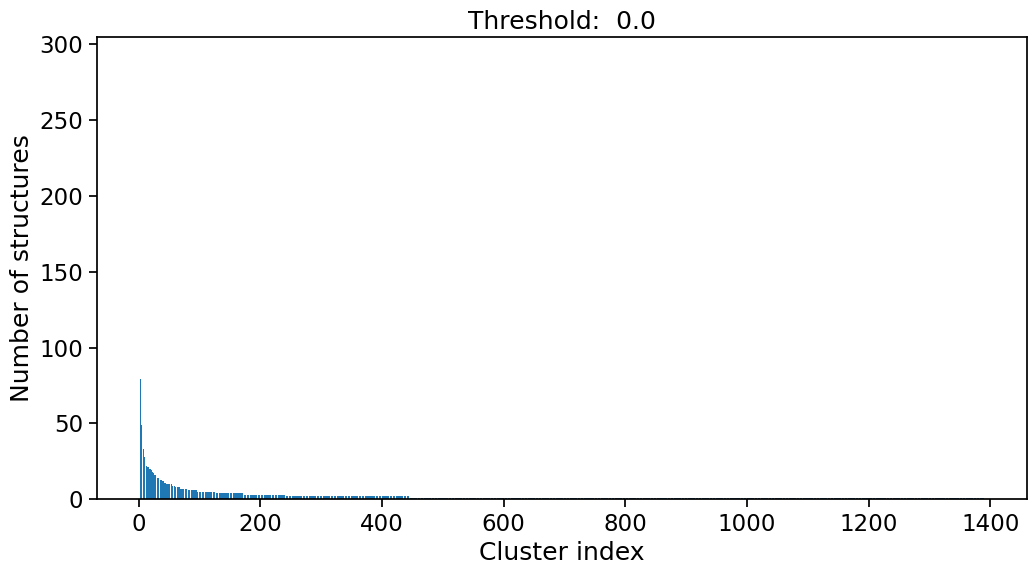

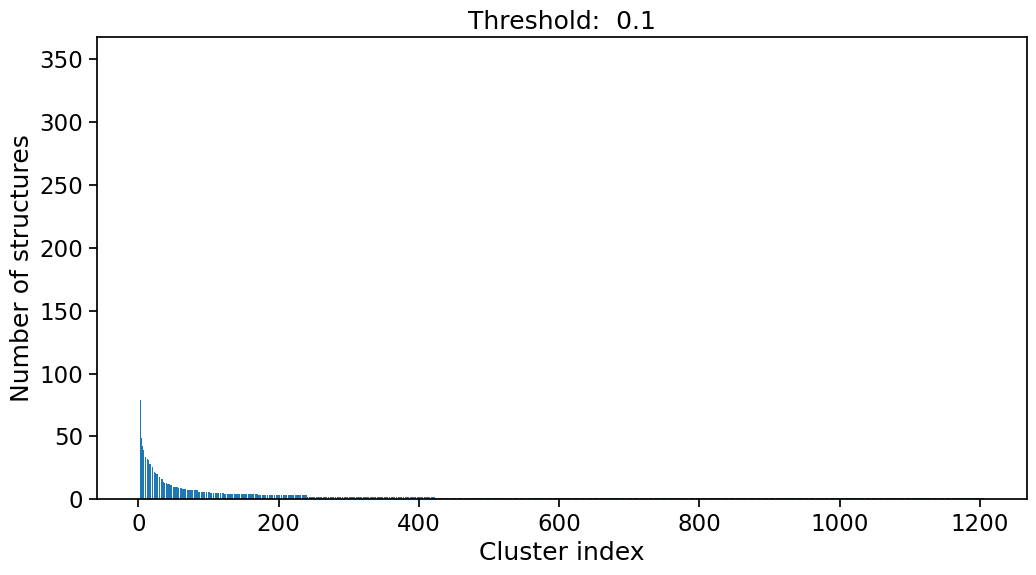

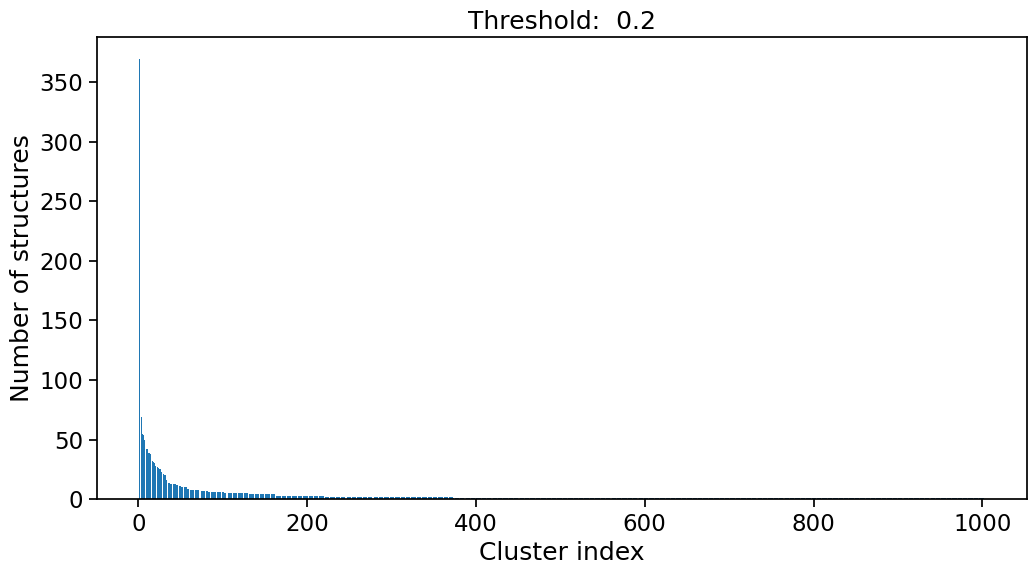

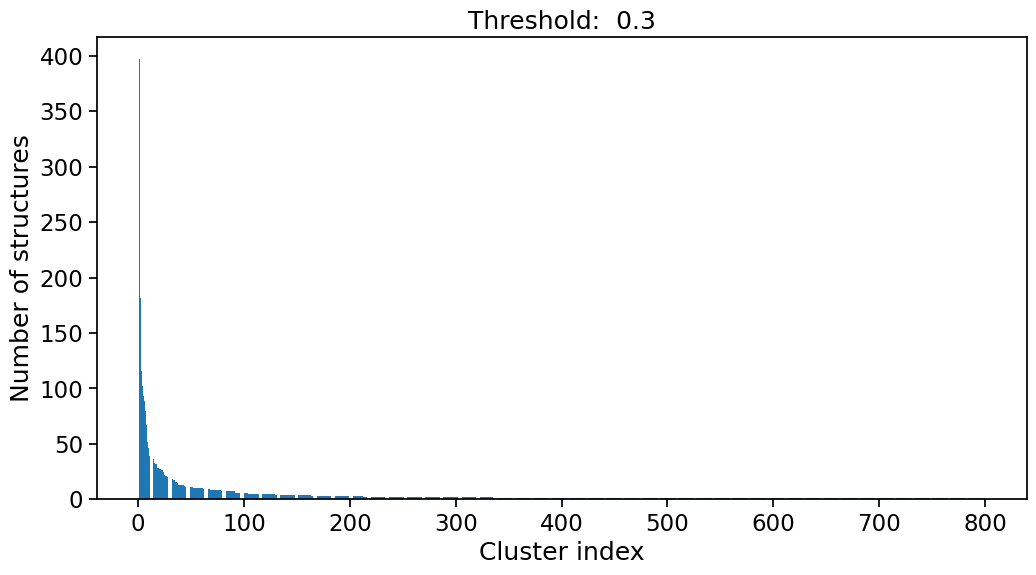

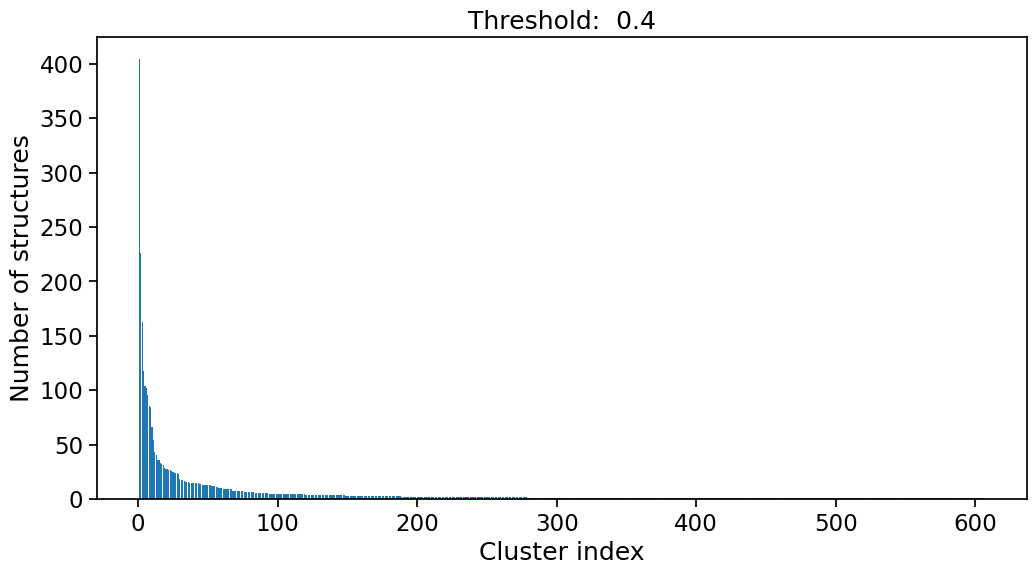

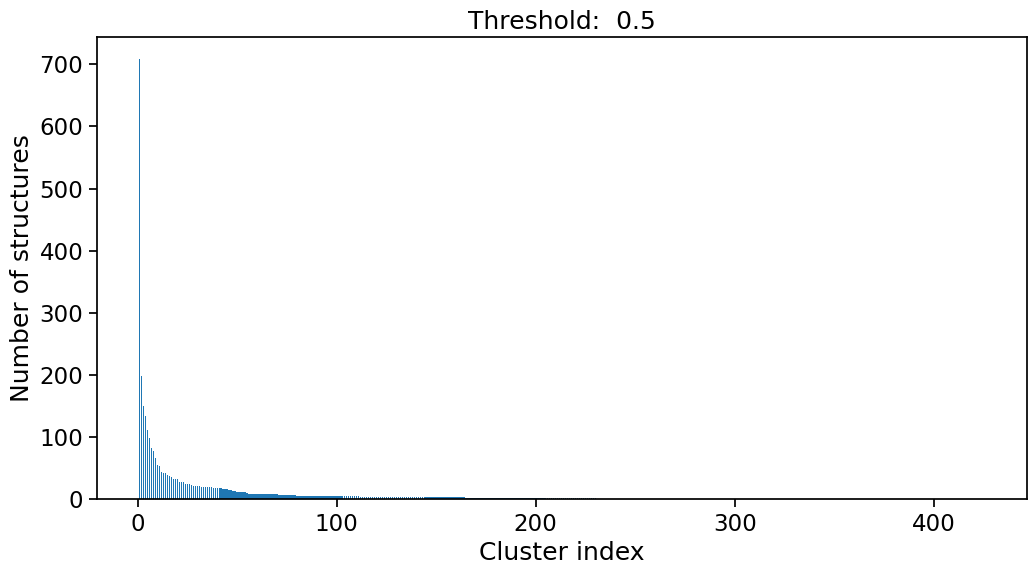

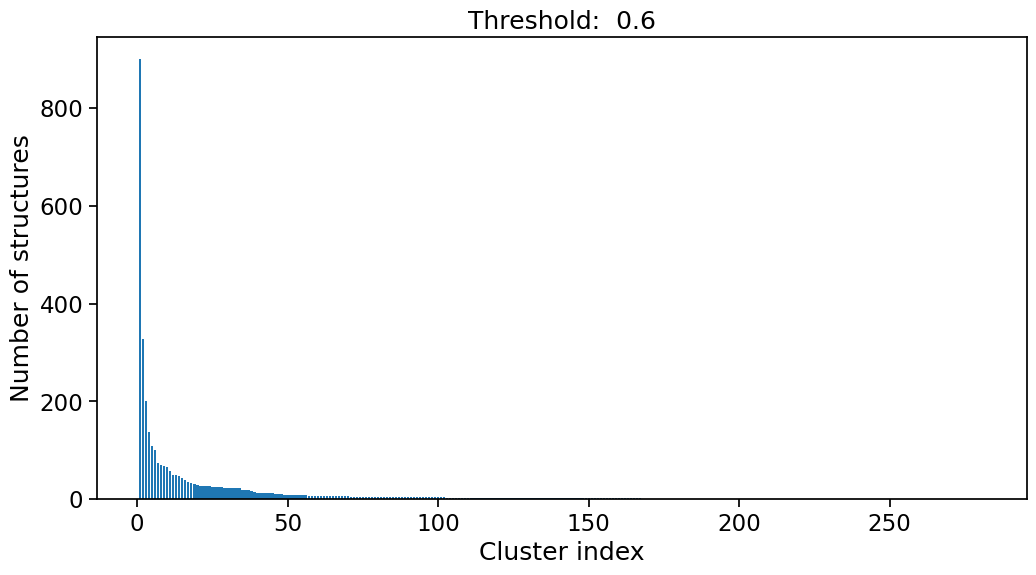

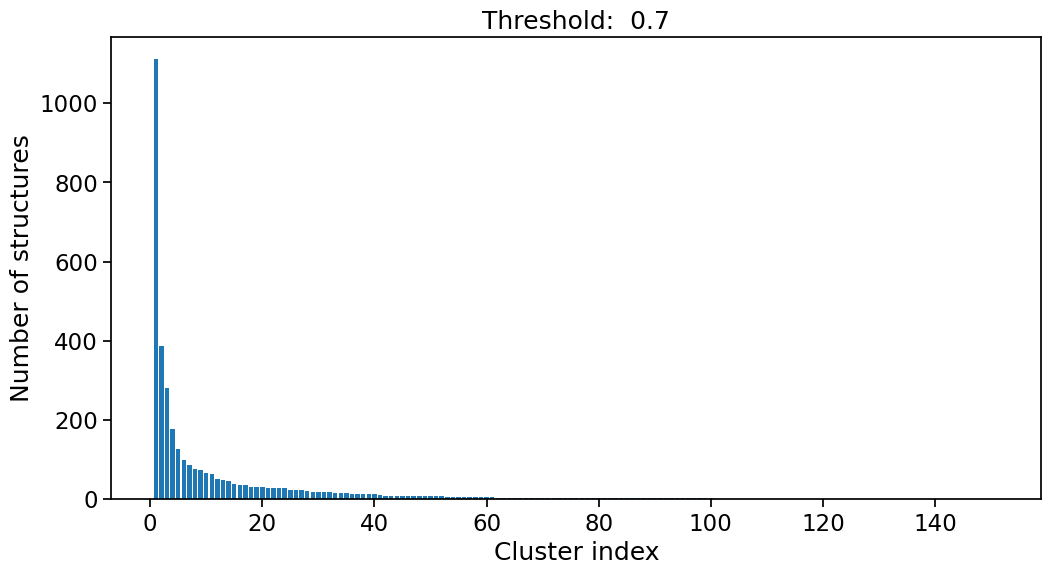

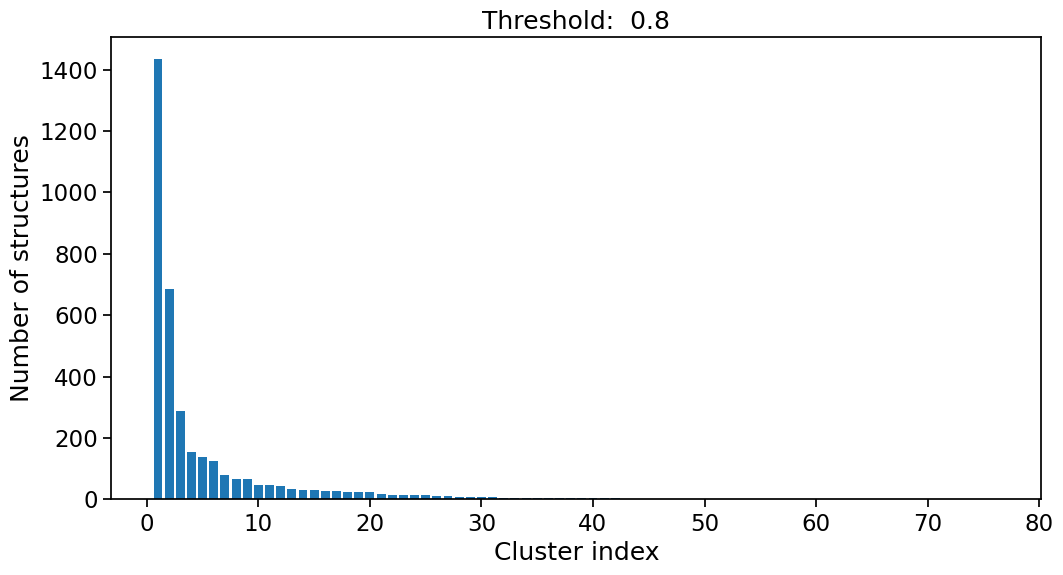

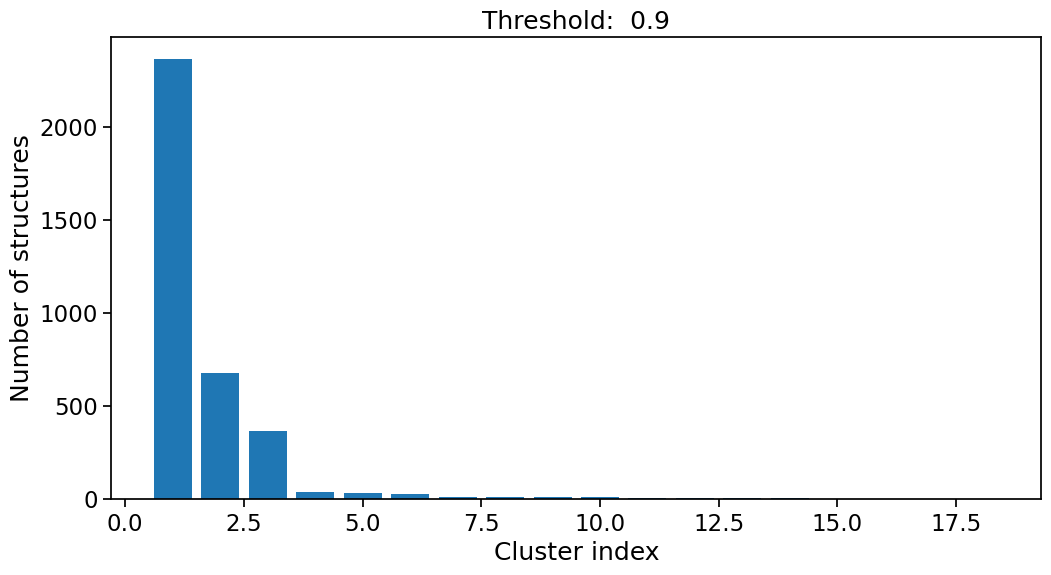

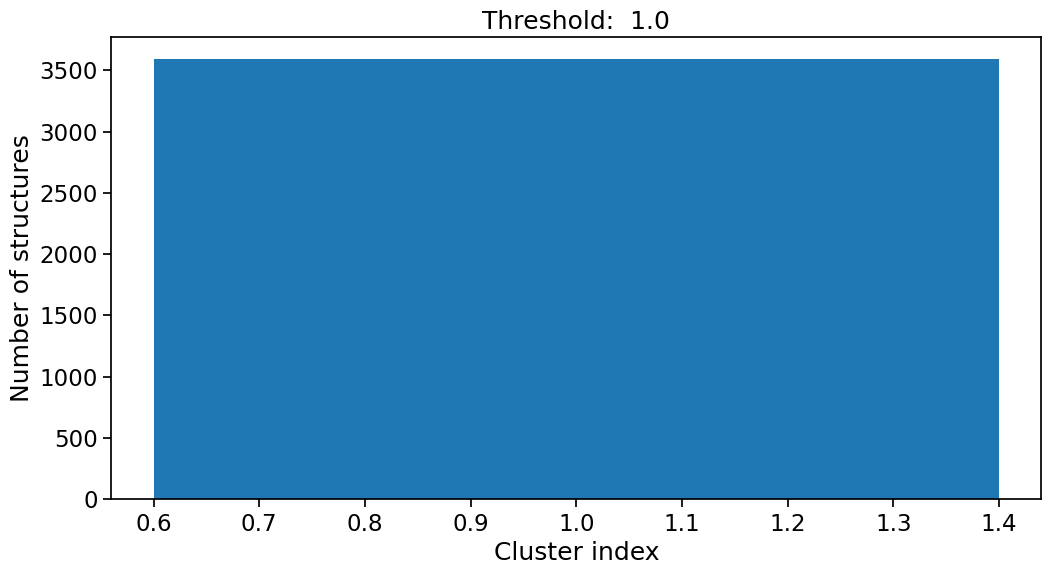

In [10]:
sns.set_context('notebook', font_scale=1.5)
cutoffs = np.arange(0.0, 1.1, 0.1)

for cutoff in cutoffs:
    clusters = cluster_fingerprints(fingerprints=fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f'Threshold: {cutoff: 3.1f}')
    ax.set_xlabel('Cluster index')
    ax.set_ylabel('Number of structures')
    ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], lw=5)

I liked the option where the dissimilarity threshold is 0.2, let's see how this goes.

Text(0.5, 1.0, 'Threshold of dissimilarity: 0.1')

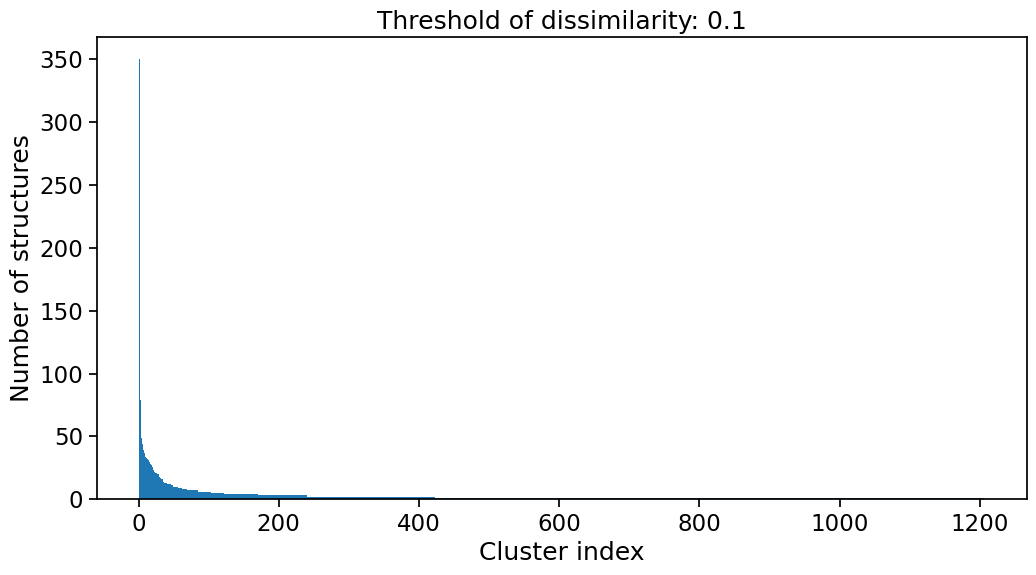

In [11]:
# Final selection of threshold
cutoff = 0.1
clusters = cluster_fingerprints(fingerprints=fingerprints, cutoff=cutoff)

# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Number of structures')
ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], width=1.2)
ax.set_title(f'Threshold of dissimilarity: {cutoff}')

In [12]:
print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} ring fragments",
    f"\n Number of RF in the first 10 clusters: {sum([len(clusters[x]) for x in range(0,10)])}",
    f"\n Number of RF in the first 20 clusters: {sum([len(clusters[x]) for x in range(0,20)])}",
    f"\n Number of RF in the first 50 clusters: {sum([len(clusters[x]) for x in range(0,50)])}",
    f"\n Number of RF in the first 100 clusters: {sum([len(clusters[x]) for x in range(0,100)])} "
)

Number of clusters: 1206 from 3590 ring fragments 
 Number of RF in the first 10 clusters: 797 
 Number of RF in the first 20 clusters: 1091 
 Number of RF in the first 50 clusters: 1558 
 Number of RF in the first 100 clusters: 1929 


## Basic Visualization

### Top 50 Cluster Fragments

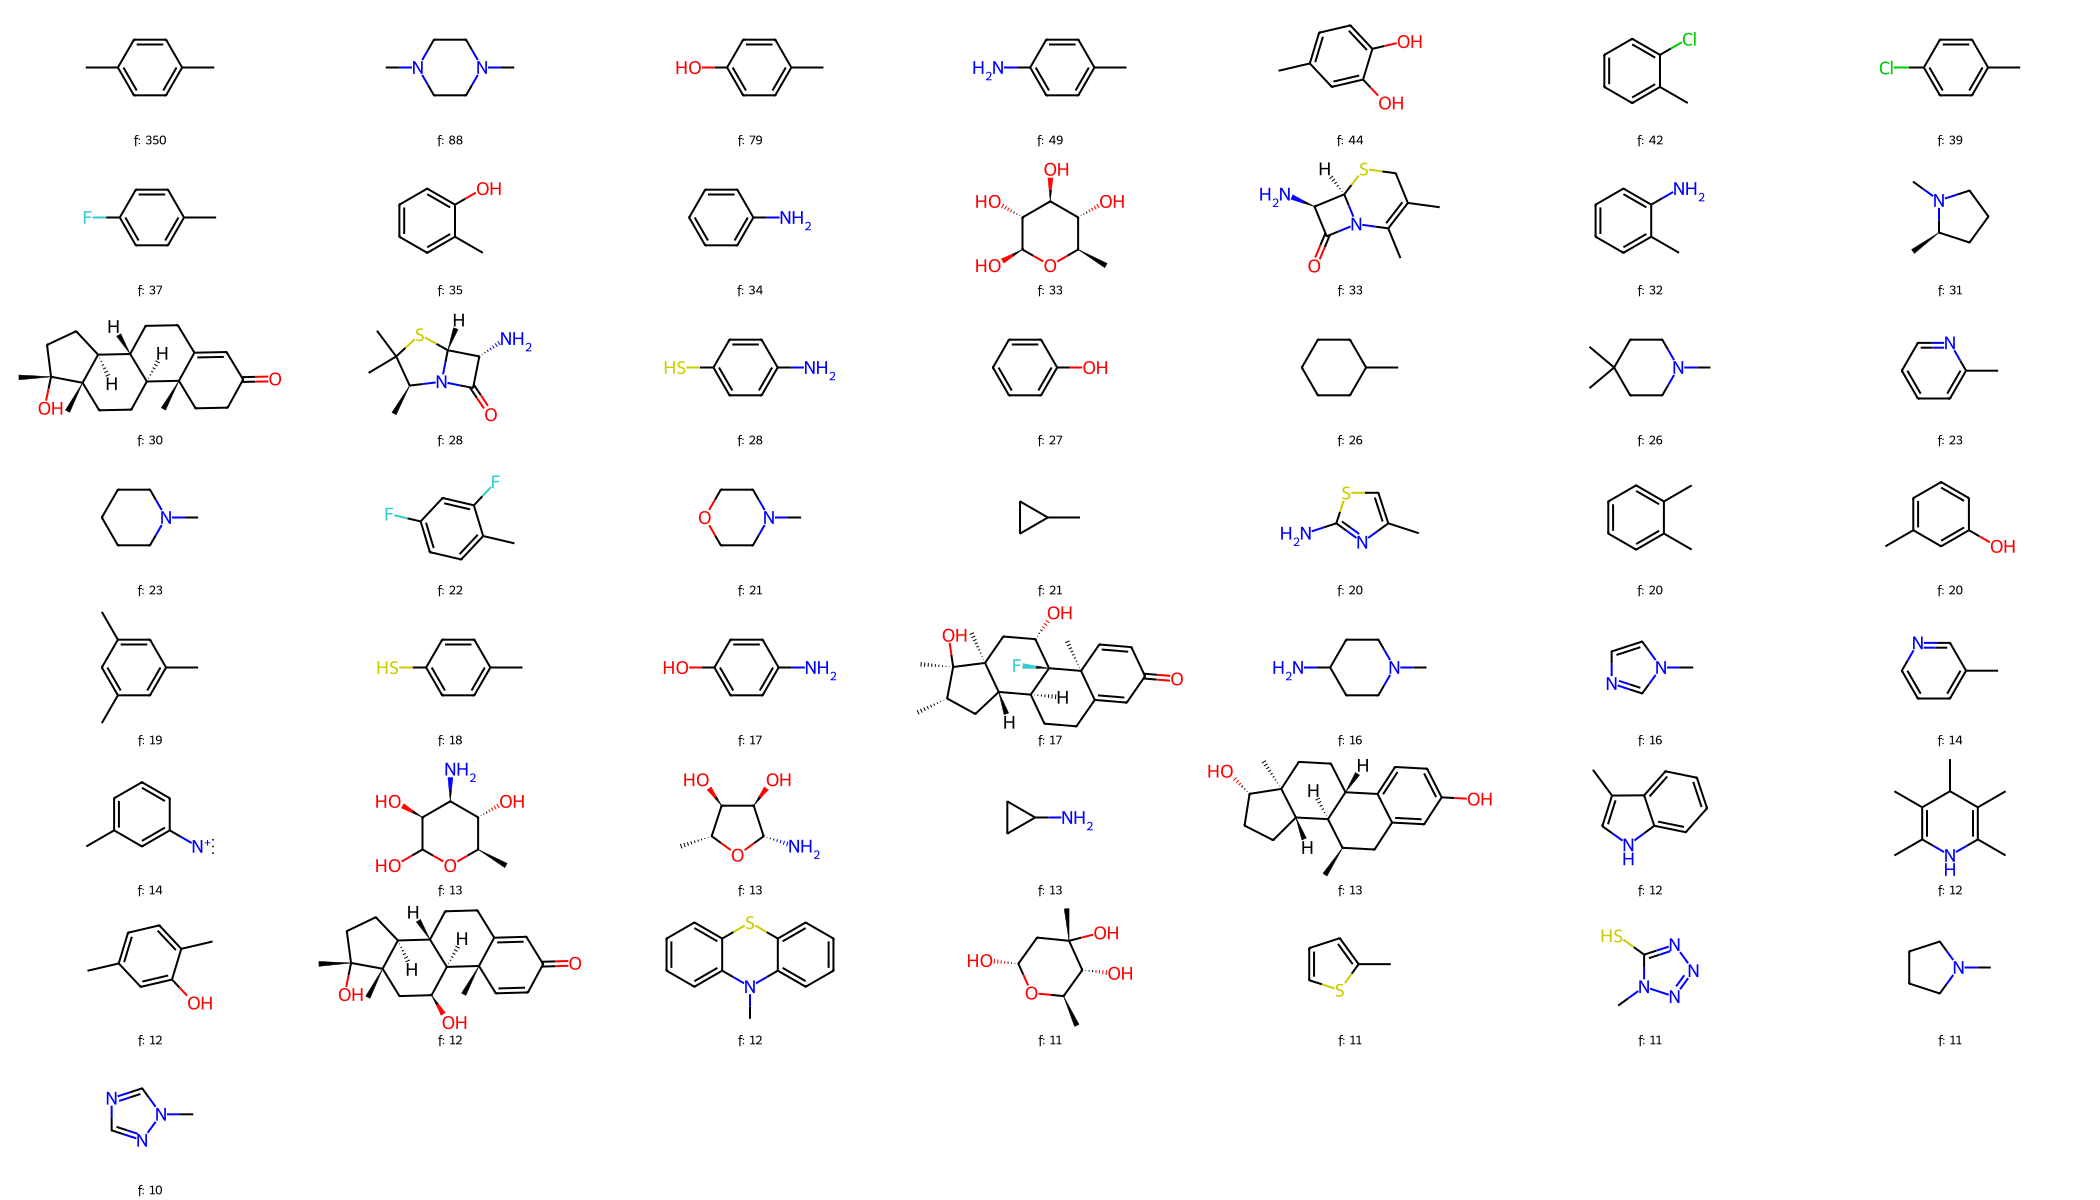

In [31]:
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.fixedFontSize = 18

def draw_top_n_centroids(n, clusters, compounds, molsPerRow):
    centroids = [cluster[0] for cluster in clusters[0:n]]
    mols = [compounds[c][0] for c in centroids]
   
    return Draw.MolsToGridImage(
        mols,
        legends= [f'f: {len(c)}' for c in clusters[0:n]],
        molsPerRow=molsPerRow,
        subImgSize=(300,150),
        maxMols=50
    )
draw_top_n_centroids(100, clusters, compounds, molsPerRow=7)

### Draw Clusters centroids with Highlighted atoms 

In [32]:
## For each cluster, retrieve a maximum common substructure smarts
def get_clusters_mcs(clusters):
    mcs_clusters = []
    for cluster in clusters:
        cluster_mols = [compounds[idx][0] for idx in cluster]
        res = rdFMCS.FindMCS(cluster_mols)
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        mcs_clusters.append(mcs_mol)
    return mcs_clusters

In [33]:
clusters_mcs_mols = get_clusters_mcs(clusters=clusters[0:100])

# Getting mols of the first 100 clusters centroids
top_100_centroids = [cluster[0] for cluster in clusters[0:100]]
top_100_mol_centroids = [compounds[i][0] for i in top_100_centroids]
legends_top_100_centroids = [f"n = {len(c)}" for c in clusters[0:100]]

# Getting the matches
cluster_mcs_and_centroids = zip(clusters_mcs_mols, top_100_mol_centroids, legends_top_100_centroids)
matches = []
for mcs, centroid, _ in cluster_mcs_and_centroids:
    matches.append(list(centroid.GetSubstructMatch(mcs)))

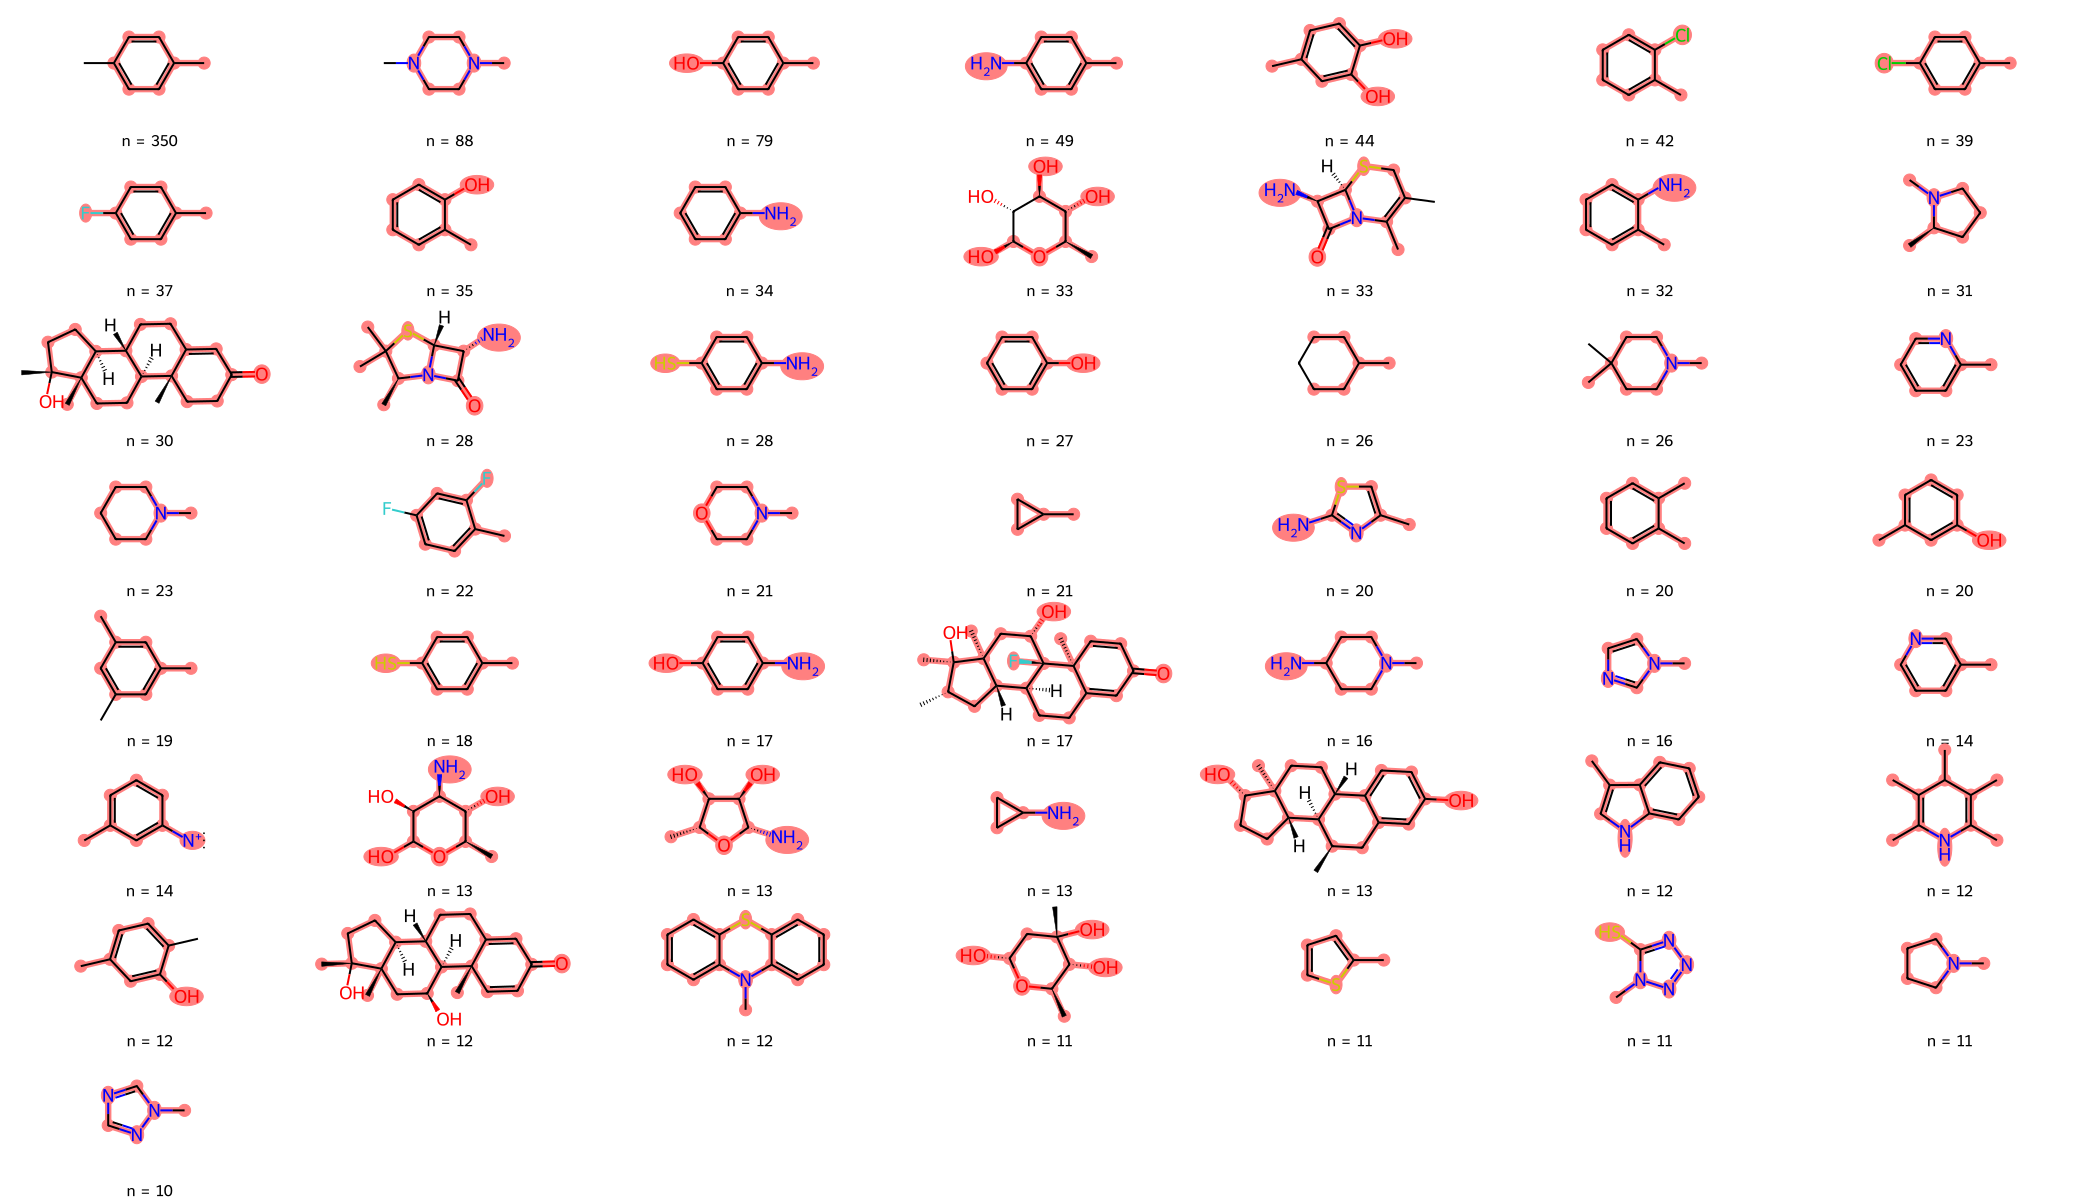

In [34]:
Draw.MolsToGridImage(
    top_100_mol_centroids[0:50], 
    highlightAtomLists=matches,
    legends=legends_top_100_centroids[0:50],
    subImgSize=(300,150), 
    molsPerRow=7)

### Separate by ring size

In [46]:
one_ring = []
matches_one_ring = []

two_rings = []
matches_two_rings = []

three_rings = []
matches_three_rings = []

four_or_more_rings = []
matches_four_or_more_rings = []

# Rings
cluster_mcs_and_centroids = zip(clusters_mcs_mols, top_100_mol_centroids, legends_top_100_centroids)
for mcs, centroid, legend in cluster_mcs_and_centroids:
    
    number_of_rings = rdMolDescriptors.CalcNumRings(centroid)
    
    if number_of_rings == 1:
        one_ring.append((centroid, legend))
        matches_one_ring.append(list(centroid.GetSubstructMatch(mcs)))

    elif number_of_rings == 2:
        two_rings.append((centroid, legend))
        matches_two_rings.append(list(centroid.GetSubstructMatch(mcs)))
    
    elif number_of_rings == 3:
        three_rings.append((centroid, legend))
        matches_three_rings.append(list(centroid.GetSubstructMatch(mcs)))
    
    else:
        four_or_more_rings.append((centroid, legend))
        matches_four_or_more_rings.append(list(centroid.GetSubstructMatch(mcs)))

In [47]:
def draw_clusters_by_ring_number(n_rings, matches, **kwargs):
    mols = [t[0] for t in n_rings]
    legend = [t[1] for t in n_rings]

    return Draw.MolsToGridImage(
        mols,
        legends= legend,
        highlightAtomLists=matches,
        subImgSize=kwargs['subImgSize'],
        molsPerRow=kwargs['molsPerRow'],
        maxMols = kwargs['maxMols']
    )

#### 1 Ring)

In [50]:
len(one_ring)

78

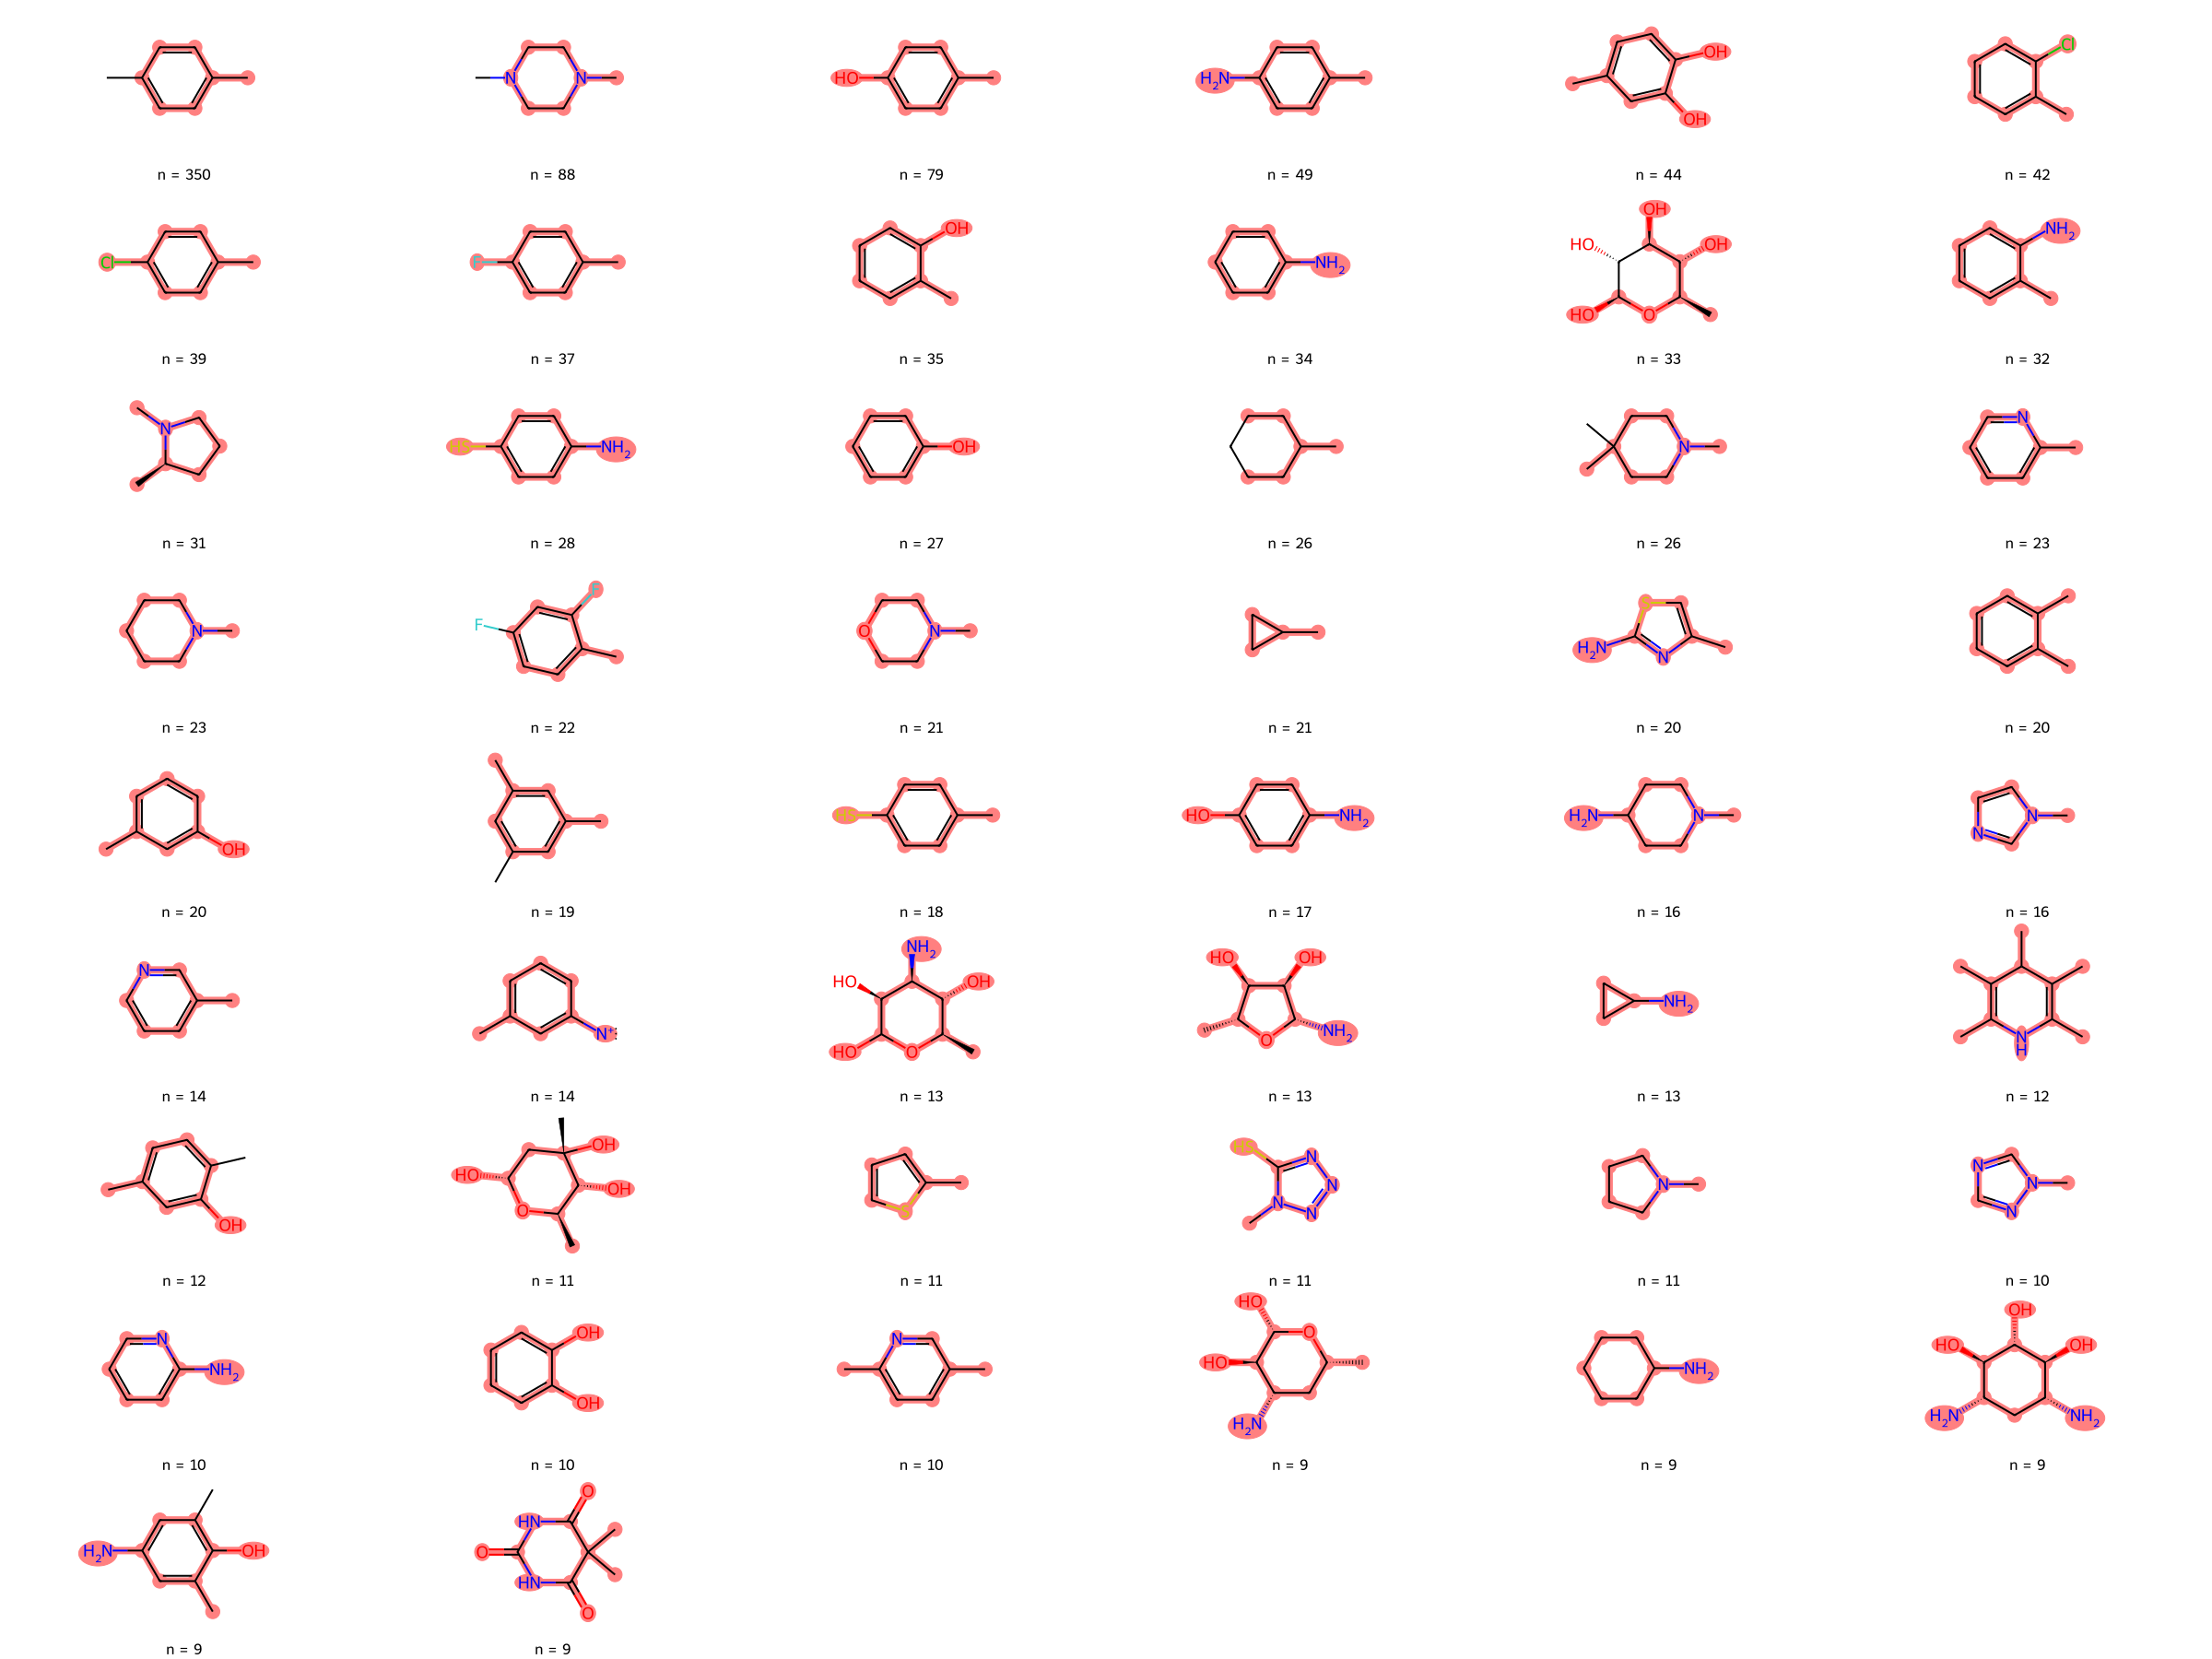

In [41]:
draw_clusters_by_ring_number(one_ring, matches=matches_one_ring, molsPerRow=6, subImgSize=(400,200), maxMols=50)

#### 2 Rings)

In [51]:
len(two_rings)

10

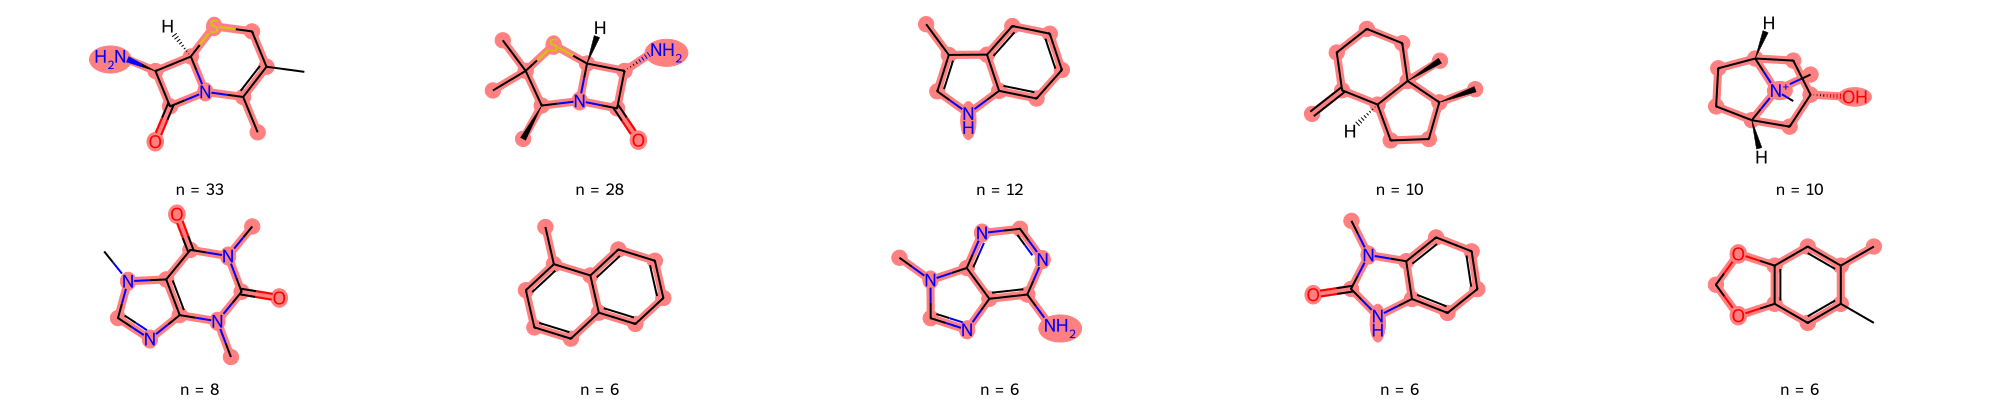

In [44]:
draw_clusters_by_ring_number(two_rings, matches=matches_two_rings,  molsPerRow=5, subImgSize=(400,200), maxMols=50)

#### 3 rings)

In [52]:
len(three_rings)

2

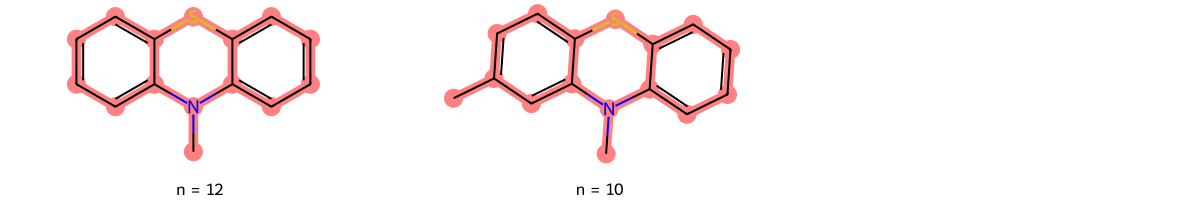

In [48]:
draw_clusters_by_ring_number(three_rings, matches=matches_three_rings,  molsPerRow=3, subImgSize=(400,200), maxMols=50)

#### 4 rings)

In [53]:
len(four_or_more_rings)

10

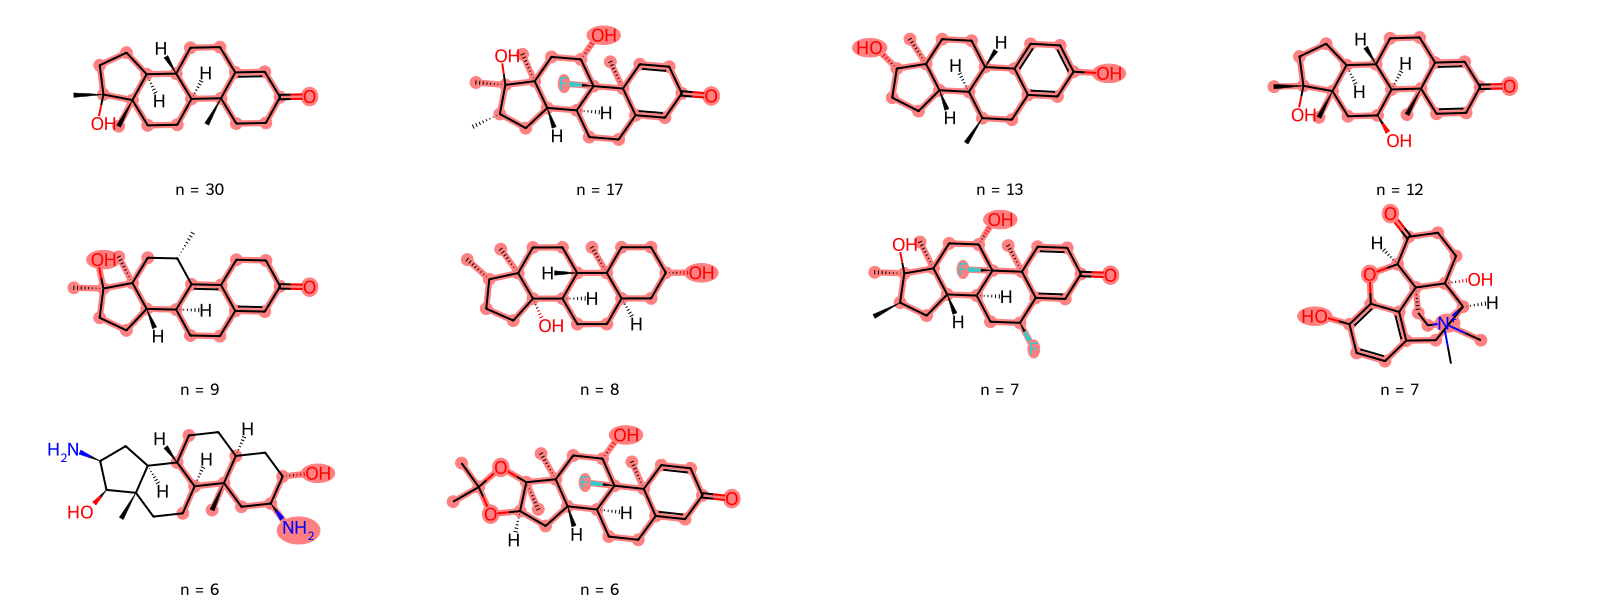

In [49]:
draw_clusters_by_ring_number(four_or_more_rings, matches=matches_four_or_more_rings, molsPerRow=4, subImgSize=(400,200), maxMols=50)